# 07 Diffuse material

* 하나의 픽셀 별로 여러 ray를 쏘고 blending해서 영상의 aliasing을 줄입니다.

In [1]:
from typing import List
import sys
from tqdm import tqdm

import numpy as np
import numpy.linalg as LA

import matplotlib.pyplot as plt

infinity = sys.float_info.max

In [2]:
def normalize(vec: np.array, eps: float = 1e-6):
    return vec / (LA.norm(vec) + eps)


def blend(color1: np.array, color2: np.array, t: float):
    return (1.0 - t) * color1 + t * color2


def normalize_color(image: np.array, num_sample_per_pixel: int):
    # divide the color by the number of samples and gamma-correct for gamma=2.0.
    scale = 1.0 / num_sample_per_pixel
    return np.sqrt(scale * image)

In [3]:
class Ray:
    def __init__(self, origin: np.array, direction: np.array) -> None:
        self.origin: np.array = origin
        self.direction: np.array = normalize(direction)

    def at(self, t: float) -> np.array:
        return self.origin + t * self.direction

In [4]:
class HitRecord:
    def __init__(self, point: np.array, normal: np.array, t: float) -> None:
        self.point = point
        self.normal = normal
        self.t = t

    def set_face_normal(self, ray: Ray, outward_normal: np.array) -> None:
        is_front_face = np.dot(ray.direction, outward_normal) < 0
        self.normal = outward_normal if is_front_face else -outward_normal

In [5]:
class Hittable:
    def hit(self, ray: Ray, t_min: float, t_max: float) -> HitRecord:
        raise NotImplementedError

In [6]:
class Sphere(Hittable):
    def __init__(self) -> None:
        self.center = np.zeros(3)
        self.radius = 1.0

    def __init__(self, center: np.array, radius: float) -> None:
        self.center = center
        self.radius = radius

    def hit(self, ray: Ray, t_min: float, t_max: float) -> bool:
        dir_center_to_origin = ray.origin - self.center

        a = np.dot(ray.direction, ray.direction)
        half_b = np.dot(dir_center_to_origin, ray.direction)
        c = np.dot(dir_center_to_origin, dir_center_to_origin) - self.radius**2.0

        discriminant = half_b**2 - a * c
        if discriminant < 0:
            return None
        sqrt_d = np.sqrt(discriminant)

        # find the nearest root that lies in the acceptable range.
        t = (-half_b - sqrt_d) / a
        if t < t_min or t_max < t:
            t = (-half_b + sqrt_d) / a
            if t < t_min or t_max < t:
                return None

        point = ray.at(t)
        outward_normal = (point - self.center) / self.radius
        hit_record = HitRecord(point=point, normal=outward_normal, t=t)
        hit_record.set_face_normal(ray=ray, outward_normal=outward_normal)

        return hit_record

In [7]:
class HittableList(Hittable):
    def __init__(self) -> None:
        self.objects: List[Hittable] = []

    def clear(self) -> None:
        self.objects.clear()

    def add(self, object: Hittable) -> None:
        self.objects.append(object)

    def hit(self, ray: Ray, t_min: float, t_max: float) -> HitRecord:
        record = None
        closest_so_far = t_max

        for object in self.objects:
            tmp_record = object.hit(ray=ray, t_min=t_min, t_max=closest_so_far)
            if tmp_record is not None:
                closest_so_far = tmp_record.t
                record = tmp_record

        return record

In [8]:
class Camera:
    def __init__(self) -> None:
        self.aspect_ratio = 16.0 / 9.0
        self.viewport_height = 2.0
        self.viewport_width = self.aspect_ratio * self.viewport_height
        self.focal_length = 1.0

        self.origin = np.array([0.0, 0.0, 0.0])
        self.horizontal_vec = np.array([self.viewport_width, 0.0, 0.0])
        self.vertical_vec = np.array([0.0, self.viewport_height, 0.0])
        self.frontal_vec = np.array([0.0, 0.0, self.focal_length])
        self.lower_left_corner = (
            self.origin
            - self.horizontal_vec / 2.0
            - self.vertical_vec / 2.0
            - self.frontal_vec
        )

    def get_ray(self, u: float, v: float) -> Ray:
        return Ray(
            origin=self.origin,
            direction=(
                self.lower_left_corner + u * self.horizontal_vec + v * self.vertical_vec
            )
            - self.origin,
        )

In [9]:
def random_in_unit_sphere() -> np.array:
    p = np.random.uniform(low=-1.0, high=1.0, size=[3])
    return normalize(p)

In [10]:
def ray_color(ray: Ray, world: Hittable, depth: int) -> np.array:
    if depth <= 0:
        color = np.zeros(3)
        return color

    record = world.hit(ray=ray, t_min=0.0, t_max=infinity)
    if record is not None:
        target = record.point + record.normal + random_in_unit_sphere()
        new_ray = Ray(origin=record.point, direction=target - record.point)
        return 0.5 * ray_color(ray=new_ray, world=world, depth=depth - 1)

    t = 0.5 * (ray.direction[1] + 1.0)
    color1 = np.array([1.0, 1.0, 1.0])
    color2 = np.array([0.5, 0.7, 1.0])
    return blend(color1=color1, color2=color2, t=t)

In [11]:
# image
aspect_ratio = 16.0 / 9.0
image_width = 320
image_height = int(image_width / aspect_ratio)
num_sample_per_pixel = 10
max_depth = 5

image = np.zeros([image_height, image_width, 3])

In [12]:
# world
world = HittableList()
world.add(Sphere(center=np.array([0.0, 0.0, -1.0]), radius=0.5))
world.add(Sphere(center=np.array([0.0, -100.5, -1.0]), radius=100.0))

In [13]:
# camera
camera = Camera()

In [14]:
%%time

for row in tqdm(range(image_height)):
  for col in range(image_width):
    for _ in range(num_sample_per_pixel):
      u = (col + np.random.uniform(low=0.0, high=1.0)) / (image_width - 1)
      v = (row + np.random.uniform(low=0.0, high=1.0)) / (image_height - 1)
      ray = camera.get_ray(u, v)
      image[row, col] += ray_color(ray=ray, world=world, depth=max_depth)
      
image = normalize_color(image, num_sample_per_pixel=num_sample_per_pixel)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:49<00:00,  4.00it/s]

CPU times: total: 50 s
Wall time: 50 s


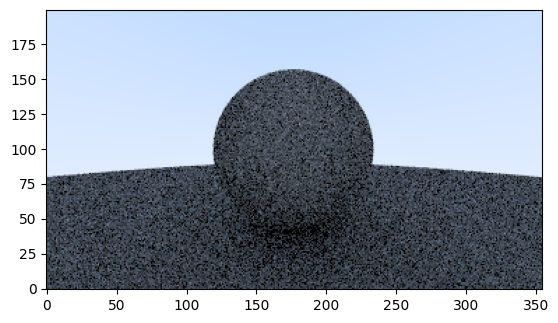

In [15]:
plt.imshow(image, origin="lower")
plt.show()